In [1]:
import pickle
import warnings
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from utility_functions import model_evaluate, preprocess_data

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", 200)
sns.set_context("talk", font_scale=1)

In [3]:
data = pd.read_pickle("data/processed_training_data.pkl")
val_data = pd.read_pickle("data/processed_validation_data.pkl")

In [4]:
data.head()

,Tweet,Depressive
0,severely depressed summer seriously thought haveis not depression anymore surpassed first holder new worse mental illness,1
1,like wake panic knowing thing get done today already dreading moment foot touch ground mentalhealthissues anxienty depression,1
2,bpd anxiety depression,1
3,depression make forget trying not gain weight,1
4,really survive depression,1


In [5]:
data.tail()

,Tweet,Depressive
1081861,woke no school best feeling ever,0
1081862,thewdb com cool hear old walt interview,0
1081863,ready mojo makeover ask detail,0
1081864,happy th birthday boo time tupac amaru shakur,0
1081865,happy charitytuesday,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data["Tweet"], data["Depressive"]
                                                    , test_size=.05
                                                    , stratify=data["Depressive"]
                                                    , random_state=42)

In [7]:
## Count vectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=300000)

count_train = count_vectorizer.fit_transform(X_train, y_train)
count_test = count_vectorizer.transform(X_test)

In [8]:
print('No. of feature_words: ', len(count_vectorizer.get_feature_names()))

No. of feature_words:  300000


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     43808
           1       0.83      0.83      0.83     10286

    accuracy                           0.94     54094
   macro avg       0.90      0.89      0.89     54094
weighted avg       0.93      0.94      0.93     54094



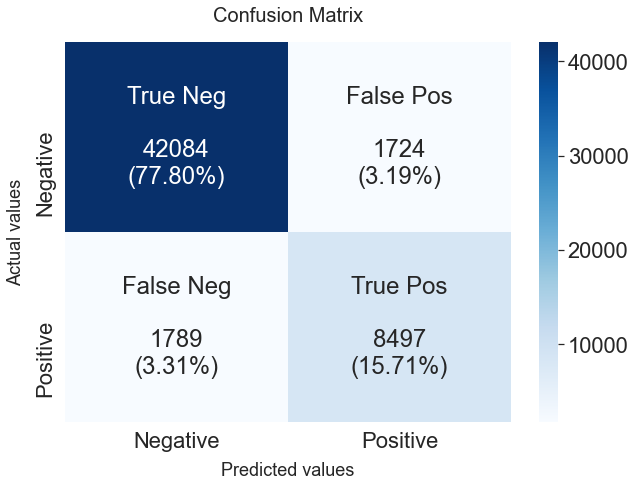

In [9]:
count_nb = MultinomialNB()
count_nb.fit(count_train, y_train)
count_pred = pd.Series(model_evaluate(count_nb, count_test, y_test))

In [10]:
val_x = val_data.iloc[:, lambda val_x: [0]]
val_y = val_data.iloc[:, lambda val_y: [1]]
val_x = val_x.squeeze()
val_y = val_y.squeeze()

In [11]:
count_val_x = count_vectorizer.transform(val_x)

              precision    recall  f1-score   support

           0       0.82      0.70      0.76      2357
           1       0.41      0.57      0.48       843

    accuracy                           0.67      3200
   macro avg       0.61      0.64      0.62      3200
weighted avg       0.71      0.67      0.68      3200



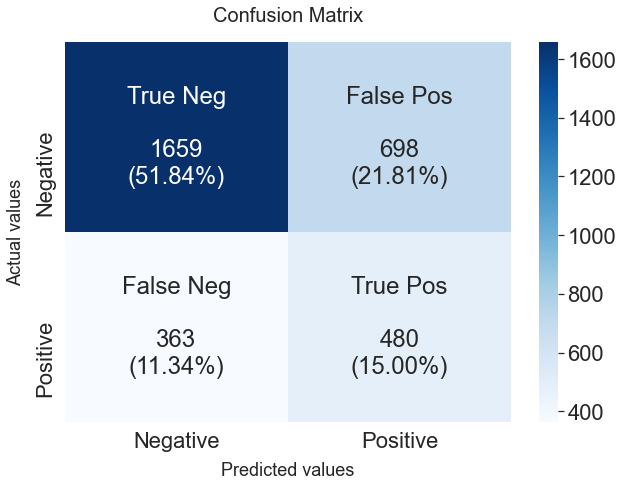

In [12]:
count_pred = pd.Series(model_evaluate(count_nb, count_val_x, val_y))

In [16]:
mnb_classifier = Pipeline([('vect', CountVectorizer()),
                      ('clf', MultinomialNB())])

In [19]:
parameters = {
                    'vect__ngram_range': [(1, 2), (1, 3)],
                    'vect__max_features': (100000, 200000, 500000),    
                    'clf__alpha': (0.005, 0.05, 0.5, 1.0)
            }

In [ ]:
mnb_gs_clf = GridSearchCV(mnb_classifier, parameters, n_jobs=-1, verbose=1, cv=5)
mnb_gs_clf.fit(X_train, y_train)

best_parameters = mnb_gs_clf.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
mnb_gs_clf_pred = pd.Series(model_evaluate(mnb_gs_clf, X_test, y_test))